# So sánh Thuật toán Optimization trên bài toán Ackley Function

## Comparison: Hill Climbing (Traditional) vs Firefly Algorithm

### Ackley Function
- **Type**: Continuous optimization benchmark
- **Global minimum**: f(0, 0, ..., 0) = 0
- **Domain**: typically [-5, 5]^d
- **Characteristics**: Nhiều local minima, test khả năng escape local optima

## Các metrics đánh giá:
1. **Convergence Speed** (Tốc độ hội tụ): Tốc độ đạt được global minimum
2. **Computational Complexity** (Độ phức tạp tính toán): Số evaluations và thời gian
3. **Robustness** (Tính bền vững): Consistency across different dimensions
4. **Scalability** (Khả năng mở rộng): Performance khi tăng dimensions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from typing import List, Tuple, Dict
import sys
import os

# Add parent directory to path
sys.path.insert(0, os.path.abspath(".."))

from src.swarm_algo.firefly import Firefly
from src.search_algo.hill_climbing import HillClimbing, Problem
from src.problem.ackley import AckleyFunction

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

In [2]:
# Reload modules after fixing encoding issue
import importlib
import sys

if "src.problem.ackley" in sys.modules:
    importlib.reload(sys.modules["src.problem.ackley"])
    print("✅ Reloaded AckleyFunction module")

✅ Reloaded AckleyFunction module


## 1. Load Data và Helper Functions

In [3]:
ACKLEY_DATA_FOLDER = "../data/ackley/"
BOUNDS = (-5.0, 5.0)  # Ackley domain


def get_ackley_problem(problem_num: int) -> Tuple[int, np.ndarray, float]:
    """Load Ackley problem using AckleyFunction class"""
    ackley = AckleyFunction(PROBLEM_FOLDER=ACKLEY_DATA_FOLDER, PROBLEM=problem_num)
    return ackley.dimension, ackley.input_vector, ackley.initial_value


def calculate_error_percentage(result_value, optimal_value=0.0):
    """Calculate error percentage from optimal (0 for Ackley)"""
    # For minimization: lower is better
    # Error = |result - optimal| / (|optimal| + epsilon)
    epsilon = 1e-10
    if optimal_value == 0:
        return abs(result_value) * 100  # Percentage
    return abs(result_value - optimal_value) / (abs(optimal_value) + epsilon) * 100

## 2. Implement Algorithm Wrappers

In [4]:
class AckleySolver:
    """Base solver for Ackley function"""

    def __init__(self, dimension, bounds=(-5.0, 5.0)):
        self.dimension = dimension
        self.bounds = bounds
        self.optimal_value = 0.0  # Global minimum


class AckleyProblemForHC(Problem):
    """Ackley Problem adapter for Hill Climbing using AckleyFunction class"""

    def __init__(self, problem_num: int, step_size=0.1, data_folder="../data/ackley/"):
        # Load Ackley problem using existing class
        self.ackley = AckleyFunction(PROBLEM_FOLDER=data_folder, PROBLEM=problem_num)
        self.dimension = self.ackley.dimension
        self.bounds = (-5.0, 5.0)
        self.step_size = step_size

    def generate_initial_solution(self):
        """Generate random initial solution in bounds"""
        return np.random.uniform(self.bounds[0], self.bounds[1], self.dimension)

    def evaluate(self, solution):
        """Evaluate Ackley function using AckleyFunction.calculate_fitness()"""
        return self.ackley.calculate_fitness(solution)

    def get_neighbors(self, solution):
        """Generate neighbors by perturbing each dimension"""
        neighbors = []
        for i in range(self.dimension):
            # Positive perturbation
            neighbor_pos = solution.copy()
            neighbor_pos[i] += self.step_size
            if self.bounds[0] <= neighbor_pos[i] <= self.bounds[1]:
                neighbors.append(neighbor_pos)

            # Negative perturbation
            neighbor_neg = solution.copy()
            neighbor_neg[i] -= self.step_size
            if self.bounds[0] <= neighbor_neg[i] <= self.bounds[1]:
                neighbors.append(neighbor_neg)

        return neighbors

    def is_valid(self, solution):
        """Check if solution is within bounds"""
        return np.all((solution >= self.bounds[0]) & (solution <= self.bounds[1]))


class AckleyHillClimbing(AckleySolver):
    """Hill Climbing Algorithm wrapper for Ackley"""

    def __init__(
        self, problem_num: int, bounds=(-5.0, 5.0), data_folder="../data/ackley/"
    ):
        # Load Ackley problem
        self.ackley = AckleyFunction(PROBLEM_FOLDER=data_folder, PROBLEM=problem_num)
        self.dimension = self.ackley.dimension
        self.bounds = bounds
        self.optimal_value = 0.0
        self.problem_num = problem_num

    def solve(self, max_iters=300, variant="steepest", step_size=0.1):
        """Solve using Hill Climbing"""
        start_time = time.time()

        # Create problem adapter
        problem = AckleyProblemForHC(self.problem_num, step_size)

        # Track convergence history
        convergence_history = []
        current_solution = problem.generate_initial_solution()
        current_fitness = problem.evaluate(current_solution)
        convergence_history.append(current_fitness)

        best_solution = current_solution.copy()
        best_fitness = current_fitness

        evaluations = 1  # Initial evaluation

        for iteration in range(max_iters):
            neighbors = problem.get_neighbors(current_solution)

            if not neighbors:
                break

            improved = False
            if variant == "steepest":
                best_neighbor = None
                best_neighbor_fitness = current_fitness

                for neighbor in neighbors:
                    neighbor_fitness = problem.evaluate(neighbor)
                    evaluations += 1

                    if neighbor_fitness < best_neighbor_fitness:
                        best_neighbor_fitness = neighbor_fitness
                        best_neighbor = neighbor
                        improved = True

                if improved:
                    current_solution = best_neighbor
                    current_fitness = best_neighbor_fitness

            elif variant == "first":
                for neighbor in neighbors:
                    neighbor_fitness = problem.evaluate(neighbor)
                    evaluations += 1

                    if neighbor_fitness < current_fitness:
                        current_solution = neighbor
                        current_fitness = neighbor_fitness
                        improved = True
                        break

            if current_fitness < best_fitness:
                best_fitness = current_fitness
                best_solution = current_solution.copy()

            convergence_history.append(best_fitness)

            if not improved:
                break

        end_time = time.time()

        return {
            "solution": best_solution,
            "value": best_fitness,
            "time": end_time - start_time,
            "iterations": len(convergence_history),
            "convergence_history": convergence_history,
            "evaluations": evaluations,
        }


class AckleyFirefly(AckleySolver):
    """Firefly Algorithm wrapper for Ackley"""

    def __init__(
        self, problem_num: int, bounds=(-5.0, 5.0), data_folder="../data/ackley/"
    ):
        # Load Ackley problem
        self.ackley = AckleyFunction(PROBLEM_FOLDER=data_folder, PROBLEM=problem_num)
        self.dimension = self.ackley.dimension
        self.bounds = bounds
        self.optimal_value = 0.0

    def solve(
        self,
        num_fireflies=50,
        num_generations=300,
        beta=1.0,
        gamma=1.0,
        alpha=0.2,
    ):
        """Solve using Firefly Algorithm"""
        start_time = time.time()

        # Create Firefly optimizer
        firefly = Firefly(
            ndim=self.dimension,
            num_fireflies=num_fireflies,
            beta=beta,
            gamma=gamma,
            alpha=alpha,
            problem_type="continuous",
        )

        # Firefly works in [0,1]^d, need to scale
        def scaled_objective(x_normalized):
            # Scale from [0,1] to [bounds[0], bounds[1]]
            x_scaled = x_normalized * (self.bounds[1] - self.bounds[0]) + self.bounds[0]
            return self.ackley.calculate_fitness(x_scaled)

        # For minimization, we need to negate (Firefly maximizes intensity)
        def fitness_for_minimization(x):
            return -scaled_objective(x)

        firefly.set_objective_function(fitness_for_minimization)

        best_position_norm, best_intensity, convergence_history = firefly.run(
            num_generations, visualize=False
        )

        # Scale back to original domain
        best_position = (
            best_position_norm * (self.bounds[1] - self.bounds[0]) + self.bounds[0]
        )
        best_value = -best_intensity  # Convert back (we negated for max)

        # Fix convergence history (negate back)
        convergence_history = [-h for h in convergence_history]

        end_time = time.time()

        return {
            "solution": best_position,
            "value": best_value,
            "time": end_time - start_time,
            "iterations": num_generations,
            "convergence_history": convergence_history,
            "evaluations": num_fireflies * num_generations,
        }

## 3. Benchmark Functions

In [5]:
def run_comparison(problem_numbers, algorithms_config, n_runs=5):
    """Run comparison across multiple problems with multiple runs"""
    results = []

    for prob_num in problem_numbers:
        print(f"\n{'='*70}")
        print(f"Problem {prob_num}")
        print(f"{'='*70}")

        dimension, initial_vector, initial_value = get_ackley_problem(prob_num)

        print(f"Dimension: {dimension}")
        print(f"Initial value: {initial_value:.6f}")
        print(f"Global optimum: 0.0")

        for algo_name, algo_params in algorithms_config.items():
            print(f"\nRunning {algo_name}...")

            # Run multiple times for statistical significance
            run_results = []

            for run in range(n_runs):
                try:
                    if algo_name == "Hill Climbing":
                        solver = AckleyHillClimbing(prob_num)
                        result = solver.solve(**algo_params)
                    elif algo_name == "Firefly":
                        solver = AckleyFirefly(prob_num)
                        result = solver.solve(**algo_params)

                    run_results.append(result)

                except Exception as e:
                    print(f"  Run {run+1} Error: {e}")

            # Aggregate results
            if run_results:
                values = [r["value"] for r in run_results]
                times = [r["time"] for r in run_results]
                iterations = [r["iterations"] for r in run_results]
                evaluations = [r["evaluations"] for r in run_results]

                best_run = run_results[np.argmin(values)]

                result_dict = {
                    "Problem": prob_num,
                    "Algorithm": algo_name,
                    "Dimension": dimension,
                    "Best Value": np.min(values),
                    "Mean Value": np.mean(values),
                    "Std Value": np.std(values),
                    "Mean Time (s)": np.mean(times),
                    "Std Time (s)": np.std(times),
                    "Iterations": int(np.mean(iterations)),
                    "Evaluations": int(np.mean(evaluations)),
                    "Convergence History": best_run["convergence_history"],
                }

                results.append(result_dict)

                print(f"  Best value: {np.min(values):.6f}")
                print(f"  Mean value: {np.mean(values):.6f} ± {np.std(values):.6f}")
                print(f"  Mean time: {np.mean(times):.4f}s")

    return pd.DataFrame(results)

## 4. Run Experiments

### 4.1 Low Dimensions (2D-5D)

In [6]:
# Test on low-dimensional problems
low_dim_problems = [1, 2, 3, 4]  # Typically 2D to 5D

algorithms_config = {
    "Hill Climbing": {
        "max_iters": 200,
        "variant": "steepest",
        "step_size": 0.1,
    },
    "Firefly": {
        "num_fireflies": 30,
        "num_generations": 200,
        "beta": 1.0,
        "gamma": 1.0,
        "alpha": 0.2,
    },
}

low_dim_results = run_comparison(low_dim_problems, algorithms_config, n_runs=10)
print("\n" + "=" * 70)
print("Summary for Low Dimensions")
print("=" * 70)
print(low_dim_results.drop("Convergence History", axis=1).to_string(index=False))


Problem 1
Dimension: 5
Initial value: 21.812432
Global optimum: 0.0

Running Hill Climbing...
  Best value: 6.628616
  Mean value: 9.358901 ± 1.344953
  Mean time: 0.0018s

Running Firefly...
  Best value: 1.113440
  Mean value: 1.782366 ± 0.391597
  Mean time: 0.7744s

Problem 2
Dimension: 5
Initial value: 21.670581
Global optimum: 0.0

Running Hill Climbing...
  Best value: 6.313243
  Mean value: 8.318309 ± 1.230306
  Mean time: 0.0010s

Running Firefly...
  Best value: 1.113440
  Mean value: 1.782366 ± 0.391597
  Mean time: 0.7744s

Problem 2
Dimension: 5
Initial value: 21.670581
Global optimum: 0.0

Running Hill Climbing...
  Best value: 6.313243
  Mean value: 8.318309 ± 1.230306
  Mean time: 0.0010s

Running Firefly...
  Best value: 0.643978
  Mean value: 1.500316 ± 0.481370
  Mean time: 0.7682s

Problem 3
Dimension: 5
Initial value: 21.785701
Global optimum: 0.0

Running Hill Climbing...
  Best value: 6.019468
  Mean value: 8.705469 ± 1.458608
  Mean time: 0.0009s

Running Firef

### 4.2 Medium Dimensions (10D-20D)

In [7]:
# Test on medium-dimensional problems
medium_dim_problems = [5, 6, 7]  # 10D to 20D

algorithms_config_medium = {
    "Hill Climbing": {
        "max_iters": 300,
        "variant": "steepest",
        "step_size": 0.1,
    },
    "Firefly": {
        "num_fireflies": 50,
        "num_generations": 300,
        "beta": 1.0,
        "gamma": 0.5,
        "alpha": 0.2,
    },
}

medium_dim_results = run_comparison(
    medium_dim_problems, algorithms_config_medium, n_runs=10
)
print("\n" + "=" * 70)
print("Summary for Medium Dimensions")
print("=" * 70)
print(medium_dim_results.drop("Convergence History", axis=1).to_string(index=False))


Problem 5
Dimension: 5
Initial value: 19.865241
Global optimum: 0.0

Running Hill Climbing...
  Best value: 2.884103
  Mean value: 8.300717 ± 1.881162
  Mean time: 0.0011s

Running Firefly...
  Best value: 0.967491
  Mean value: 1.401472 ± 0.367178
  Mean time: 3.1933s

Problem 6
Dimension: 5
Initial value: 0.000000
Global optimum: 0.0

Running Hill Climbing...
  Best value: 7.217312
  Mean value: 8.667025 ± 1.102060
  Mean time: 0.0009s

Running Firefly...
  Best value: 0.967491
  Mean value: 1.401472 ± 0.367178
  Mean time: 3.1933s

Problem 6
Dimension: 5
Initial value: 0.000000
Global optimum: 0.0

Running Hill Climbing...
  Best value: 7.217312
  Mean value: 8.667025 ± 1.102060
  Mean time: 0.0009s

Running Firefly...
  Best value: 0.900487
  Mean value: 1.529889 ± 0.345983
  Mean time: 3.1376s

Problem 7
Dimension: 5
Initial value: 19.004259
Global optimum: 0.0

Running Hill Climbing...
  Best value: 8.158490
  Mean value: 9.211636 ± 0.761854
  Mean time: 0.0009s

Running Firefly

### 4.3 High Dimensions (30D+)

In [8]:
# Test on high-dimensional problems
high_dim_problems = [8, 9, 10]  # 30D+

algorithms_config_high = {
    "Hill Climbing": {
        "max_iters": 500,
        "variant": "steepest",
        "step_size": 0.05,  # Smaller step for high dimensions
    },
    "Firefly": {
        "num_fireflies": 50,
        "num_generations": 500,
        "beta": 1.0,
        "gamma": 0.1,
        "alpha": 0.2,
    },
}

high_dim_results = run_comparison(high_dim_problems, algorithms_config_high, n_runs=10)
print("\n" + "=" * 70)
print("Summary for High Dimensions")
print("=" * 70)
print(high_dim_results.drop("Convergence History", axis=1).to_string(index=False))


Problem 8
Dimension: 10
Initial value: 21.446102
Global optimum: 0.0

Running Hill Climbing...
  Best value: 6.771978
  Mean value: 8.270612 ± 0.869818
  Mean time: 0.0072s

Running Firefly...
  Best value: 1.628783
  Mean value: 2.565498 ± 0.384446
  Mean time: 5.1738s

Problem 9
Dimension: 10
Initial value: 21.484128
Global optimum: 0.0

Running Hill Climbing...
  Best value: 7.726734
  Mean value: 8.778813 ± 0.678110
  Mean time: 0.0066s

Running Firefly...
  Best value: 1.628783
  Mean value: 2.565498 ± 0.384446
  Mean time: 5.1738s

Problem 9
Dimension: 10
Initial value: 21.484128
Global optimum: 0.0

Running Hill Climbing...
  Best value: 7.726734
  Mean value: 8.778813 ± 0.678110
  Mean time: 0.0066s

Running Firefly...
  Best value: 2.276673
  Mean value: 2.613742 ± 0.243036
  Mean time: 5.2253s

Problem 10
Dimension: 10
Initial value: 20.997504
Global optimum: 0.0

Running Hill Climbing...
  Best value: 7.627978
  Mean value: 9.052611 ± 0.852076
  Mean time: 0.0068s

Running 

## 5. Visualization and Analysis

In [9]:
# Combine all results
all_results = pd.concat(
    [low_dim_results, medium_dim_results, high_dim_results], ignore_index=True
)
all_results

,Problem,Algorithm,Dimension,Best Value,Mean Value,Std Value,Mean Time (s),Std Time (s),Iterations,Evaluations,Convergence History
0,1,Hill Climbing,5,6.628616,9.358901,1.344953,0.001781,0.001007,13,122,"[8.28079172575134, 8.051464590311607, 7.887741..."
1,1,Firefly,5,1.113440,1.782366,0.391597,0.774373,0.032946,200,6000,"[5.852826610700653, 3.7437010834689066, 3.7437..."
2,2,Hill Climbing,5,6.313243,8.318309,1.230306,0.000969,0.000204,14,137,"[8.501890203005077, 8.335198239613515, 8.14894..."
3,2,Firefly,5,0.643978,1.500316,0.481370,0.768229,0.013564,200,6000,"[7.321209725274146, 6.653639666904574, 6.30111..."
4,3,Hill Climbing,5,6.019468,8.705469,1.458608,0.000942,0.000234,15,141,"[8.885254975828254, 8.756256362994115, 8.64030..."
5,3,Firefly,5,1.387602,1.918845,0.252274,0.746392,0.001801,200,6000,"[6.486743480246641, 5.734228308936029, 5.73422..."
6,4,Hill Climbing,5,6.872099,9.231805,1.303111,0.000889,0.000214,14,132,"[9.189697414691157, 9.104558599690645, 8.95411..."
7,4,Firefly,5,1.256258,1.693035,0.341309,0.748833,0.013743,200,6000,"[6.161648993939863, 5.635202174453905, 4.06634..."
8,5,Hill Climbing,5,2.884103,8.300717,1.881162,0.001085,0.000250,16,157,"[6.329151319439497, 6.200219703076073, 6.05283..."
9,5,Firefly,5,0.967491,1.401472,0.367178,3.193313,0.030466,300,15000,"[7.97923845196825, 4.3980741145032844, 4.39807..."


### 5.1 Metric 1: Convergence Speed

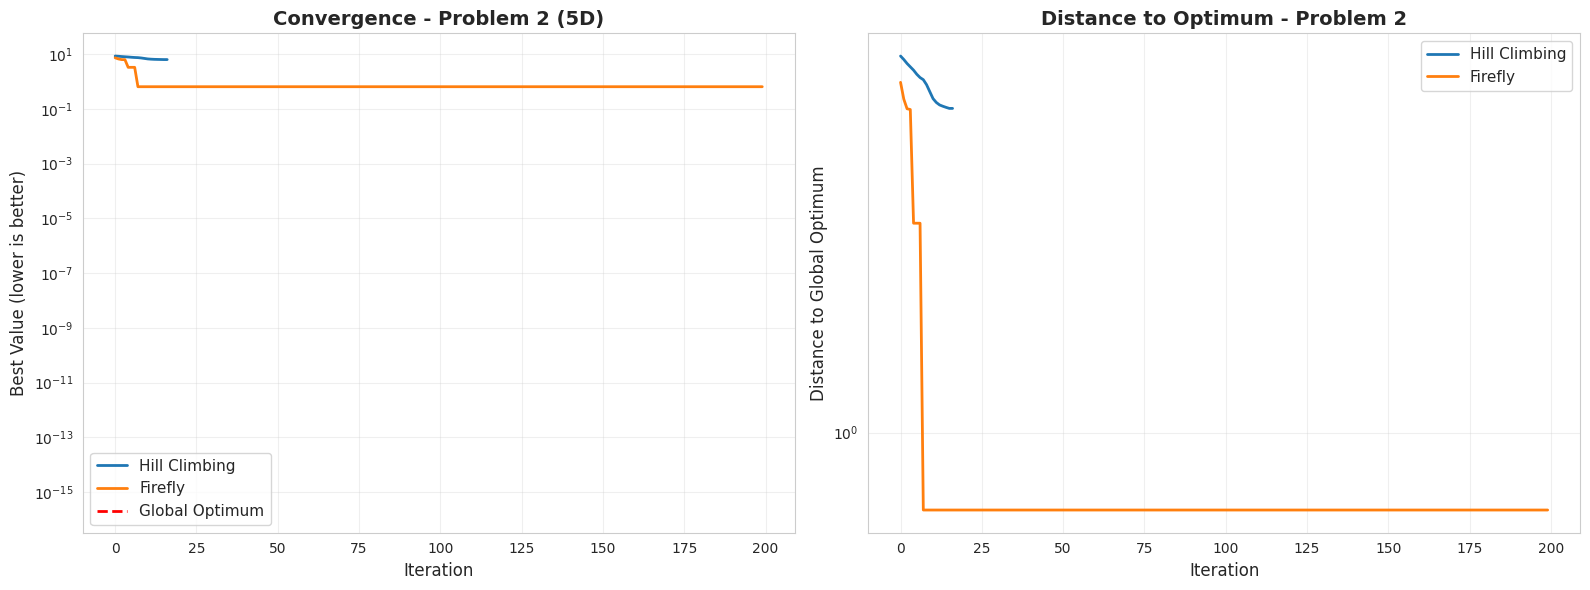

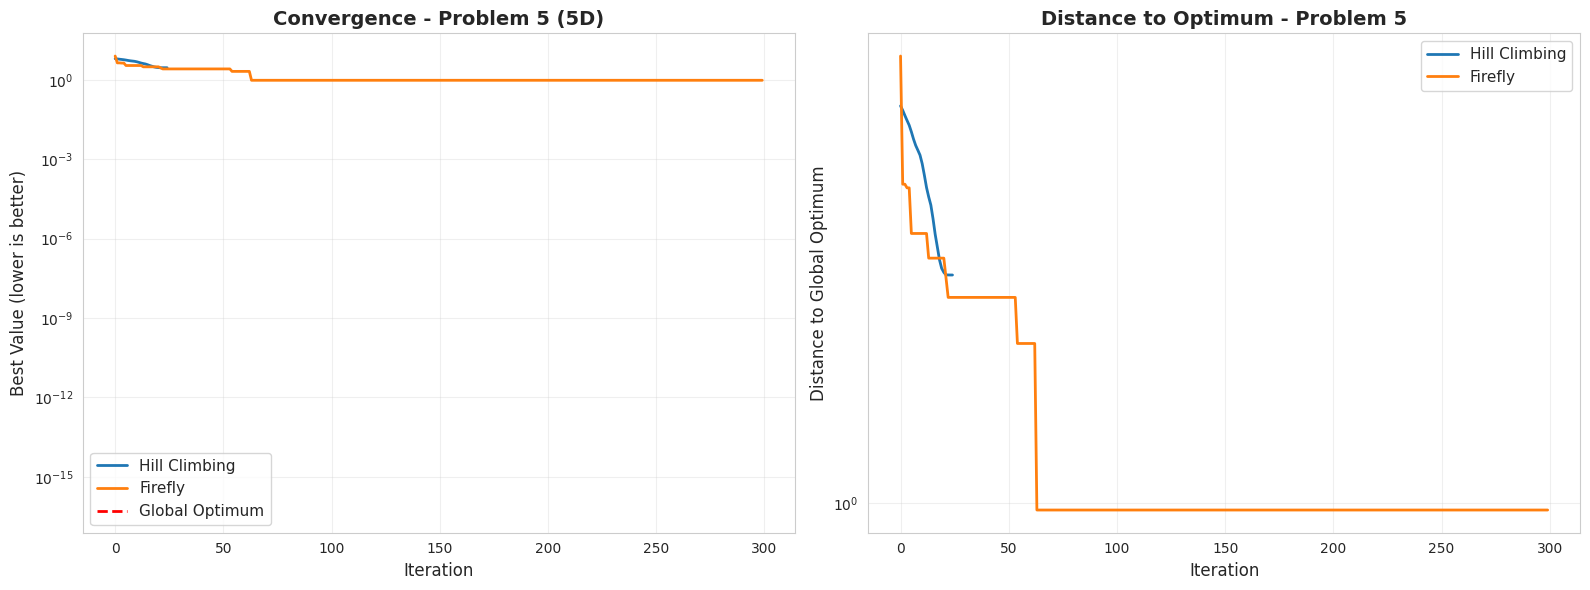

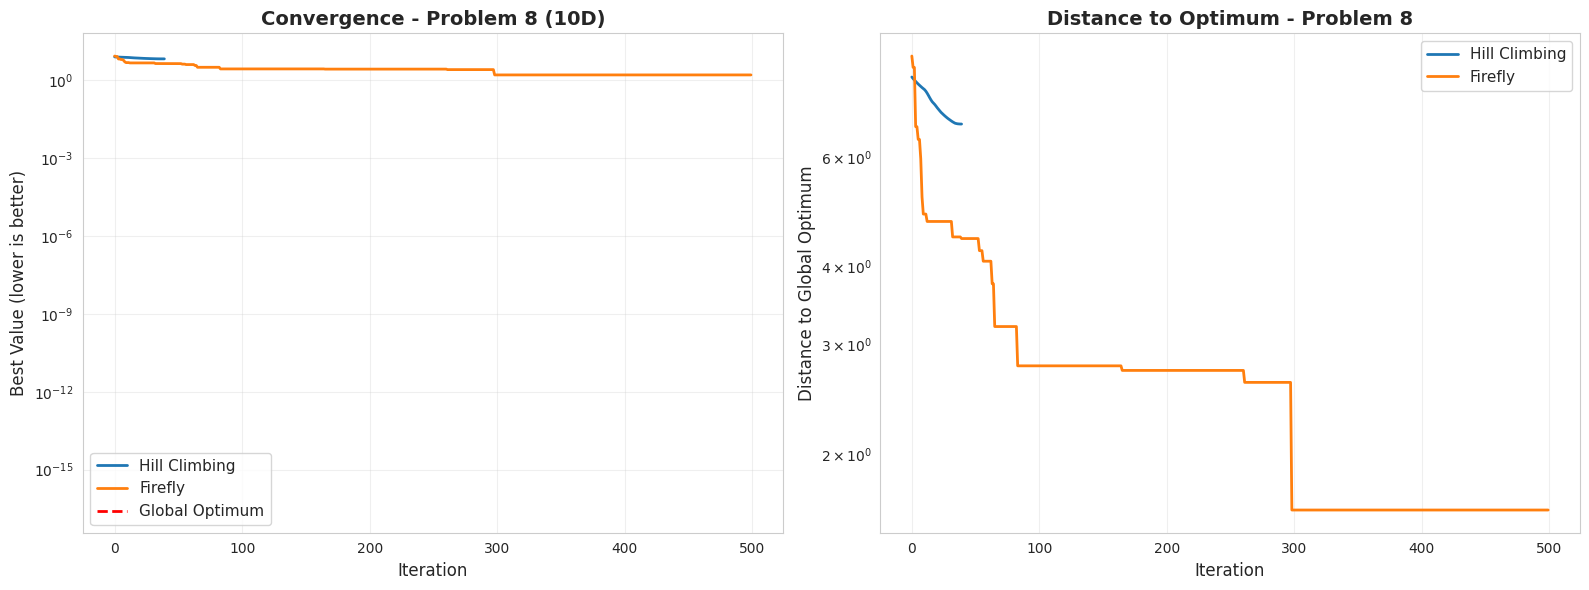

In [10]:
# Plot convergence curves
def plot_convergence(results_df, problem_num):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    problem_data = results_df[results_df["Problem"] == problem_num]

    if problem_data.empty:
        print(f"No data for problem {problem_num}")
        return

    # Plot 1: Convergence over iterations
    ax1 = axes[0]
    for _, row in problem_data.iterrows():
        history = row["Convergence History"]
        ax1.plot(history, label=row["Algorithm"], linewidth=2)

    ax1.axhline(y=0.0, color="red", linestyle="--", label="Global Optimum", linewidth=2)
    ax1.set_xlabel("Iteration", fontsize=12)
    ax1.set_ylabel("Best Value (lower is better)", fontsize=12)
    ax1.set_title(
        f"Convergence - Problem {problem_num} ({problem_data.iloc[0]['Dimension']}D)",
        fontsize=14,
        fontweight="bold",
    )
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale("log")

    # Plot 2: Distance to optimum over time
    ax2 = axes[1]
    for _, row in problem_data.iterrows():
        history = row["Convergence History"]
        distances = [abs(h - 0.0) for h in history]
        ax2.plot(distances, label=row["Algorithm"], linewidth=2)

    ax2.set_xlabel("Iteration", fontsize=12)
    ax2.set_ylabel("Distance to Global Optimum", fontsize=12)
    ax2.set_title(
        f"Distance to Optimum - Problem {problem_num}", fontsize=14, fontweight="bold"
    )
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale("log")

    plt.tight_layout()
    plt.show()


# Plot for different dimensions
for prob in [2, 5, 8]:
    if prob in all_results["Problem"].values:
        plot_convergence(all_results, prob)

### 5.2 Metric 2: Solution Quality

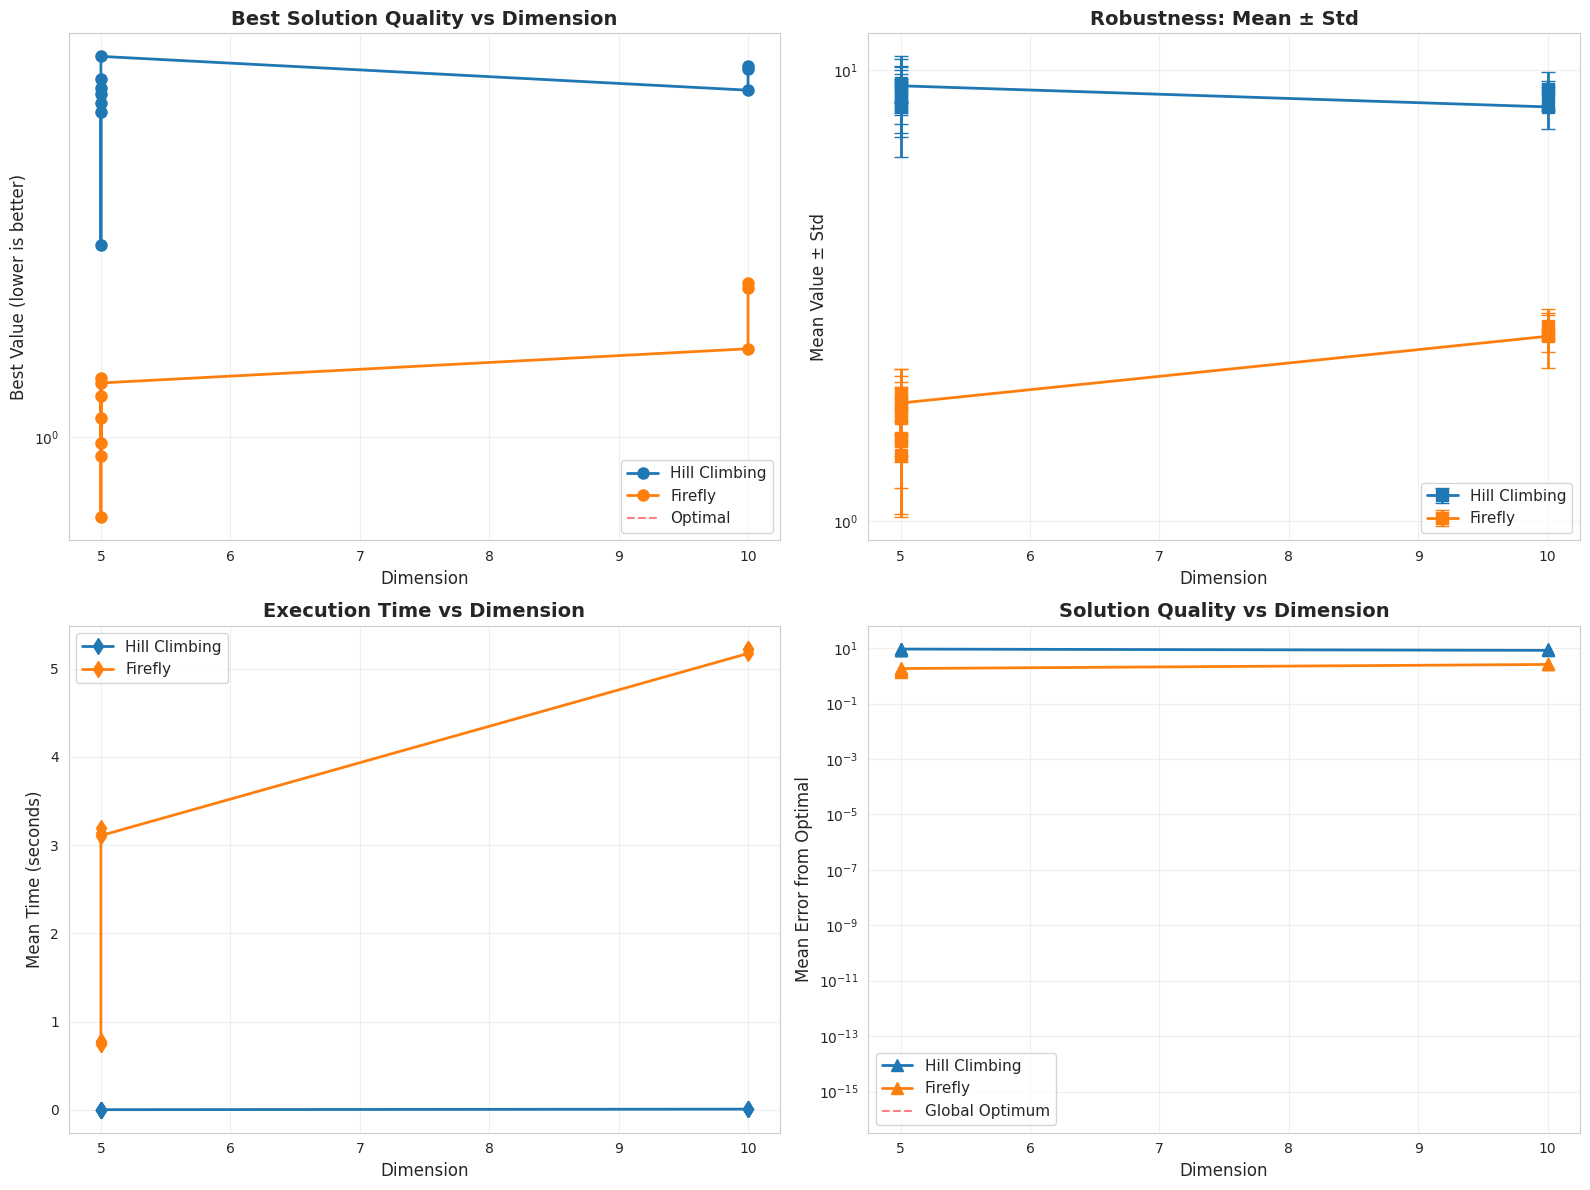

In [11]:
# Compare solution quality
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Best Value vs Dimension
ax1 = axes[0, 0]
for algo in all_results["Algorithm"].unique():
    algo_data = all_results[all_results["Algorithm"] == algo].sort_values("Dimension")
    ax1.plot(
        algo_data["Dimension"],
        algo_data["Best Value"],
        marker="o",
        label=algo,
        linewidth=2,
        markersize=8,
    )

ax1.axhline(y=0.0, color="red", linestyle="--", alpha=0.5, label="Optimal")
ax1.set_xlabel("Dimension", fontsize=12)
ax1.set_ylabel("Best Value (lower is better)", fontsize=12)
ax1.set_title("Best Solution Quality vs Dimension", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_yscale("log")

# Plot 2: Mean Value with Error Bars
ax2 = axes[0, 1]
for algo in all_results["Algorithm"].unique():
    algo_data = all_results[all_results["Algorithm"] == algo].sort_values("Dimension")
    ax2.errorbar(
        algo_data["Dimension"],
        algo_data["Mean Value"],
        yerr=algo_data["Std Value"],
        marker="s",
        label=algo,
        linewidth=2,
        markersize=8,
        capsize=5,
    )

ax2.set_xlabel("Dimension", fontsize=12)
ax2.set_ylabel("Mean Value ± Std", fontsize=12)
ax2.set_title("Robustness: Mean ± Std", fontsize=14, fontweight="bold")
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_yscale("log")

# Plot 3: Execution Time
ax3 = axes[1, 0]
for algo in all_results["Algorithm"].unique():
    algo_data = all_results[all_results["Algorithm"] == algo].sort_values("Dimension")
    ax3.plot(
        algo_data["Dimension"],
        algo_data["Mean Time (s)"],
        marker="d",
        label=algo,
        linewidth=2,
        markersize=8,
    )

ax3.set_xlabel("Dimension", fontsize=12)
ax3.set_ylabel("Mean Time (seconds)", fontsize=12)
ax3.set_title("Execution Time vs Dimension", fontsize=14, fontweight="bold")
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# Plot 4: Error from Optimal
ax4 = axes[1, 1]
for algo in all_results["Algorithm"].unique():
    algo_data = all_results[all_results["Algorithm"] == algo].sort_values("Dimension")
    ax4.plot(
        algo_data["Dimension"],
        algo_data["Mean Value"],
        marker="^",
        label=algo,
        linewidth=2,
        markersize=8,
    )

ax4.axhline(y=0.0, color="red", linestyle="--", alpha=0.5, label="Global Optimum")
ax4.set_xlabel("Dimension", fontsize=12)
ax4.set_ylabel("Mean Error from Optimal", fontsize=12)
ax4.set_title("Solution Quality vs Dimension", fontsize=14, fontweight="bold")
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.set_yscale("log")

plt.tight_layout()
plt.show()

### 5.3 Metric 3: Computational Complexity

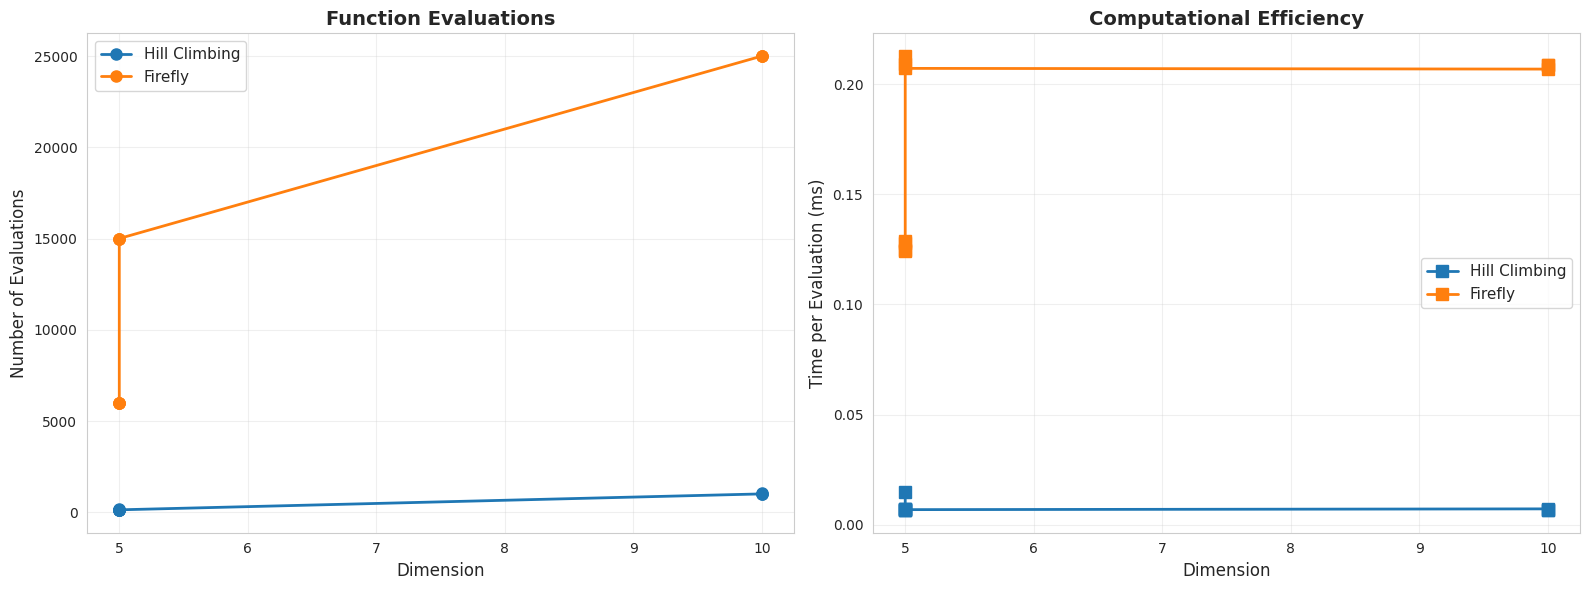


Average Metrics:
               Best Value  Mean Time (s)  Evaluations
Algorithm                                            
Firefly            1.3869         2.8103      14400.0
Hill Climbing      6.6220         0.0028        396.6


In [12]:
# Analyze computational metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Evaluations vs Dimension
ax1 = axes[0]
for algo in all_results["Algorithm"].unique():
    algo_data = all_results[all_results["Algorithm"] == algo].sort_values("Dimension")
    ax1.plot(
        algo_data["Dimension"],
        algo_data["Evaluations"],
        marker="o",
        label=algo,
        linewidth=2,
        markersize=8,
    )

ax1.set_xlabel("Dimension", fontsize=12)
ax1.set_ylabel("Number of Evaluations", fontsize=12)
ax1.set_title("Function Evaluations", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Time per Evaluation
ax2 = axes[1]
all_results["Time per Eval"] = (
    all_results["Mean Time (s)"] / all_results["Evaluations"] * 1000
)  # in ms
for algo in all_results["Algorithm"].unique():
    algo_data = all_results[all_results["Algorithm"] == algo].sort_values("Dimension")
    ax2.plot(
        algo_data["Dimension"],
        algo_data["Time per Eval"],
        marker="s",
        label=algo,
        linewidth=2,
        markersize=8,
    )

ax2.set_xlabel("Dimension", fontsize=12)
ax2.set_ylabel("Time per Evaluation (ms)", fontsize=12)
ax2.set_title("Computational Efficiency", fontsize=14, fontweight="bold")
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nAverage Metrics:")
avg_metrics = (
    all_results.groupby("Algorithm")
    .agg({"Best Value": "mean", "Mean Time (s)": "mean", "Evaluations": "mean"})
    .round(4)
)
print(avg_metrics)

### 5.4 Metric 4: Scalability Analysis

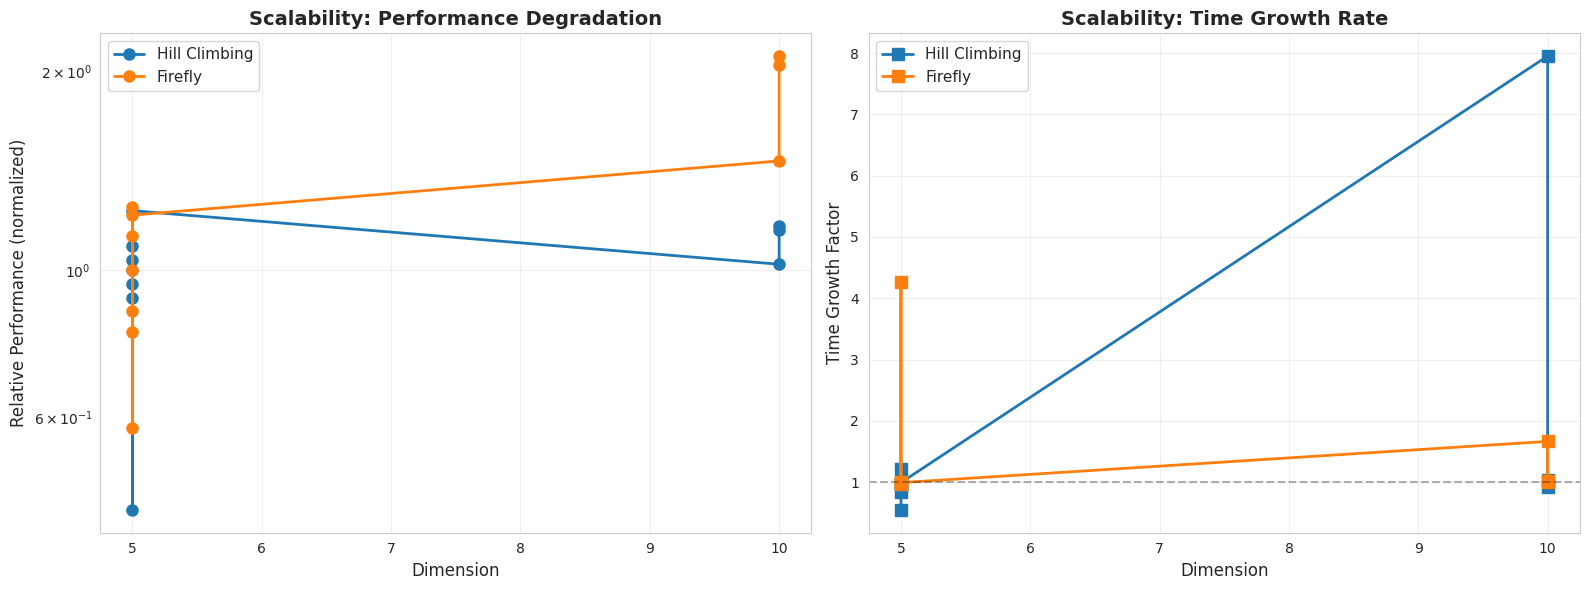

In [13]:
# Scalability analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Performance Degradation
ax1 = axes[0]
for algo in all_results["Algorithm"].unique():
    algo_data = all_results[all_results["Algorithm"] == algo].sort_values("Dimension")
    if len(algo_data) > 1:
        # Normalize by first value
        base_value = algo_data.iloc[0]["Best Value"]
        normalized = algo_data["Best Value"] / (base_value + 1e-10)
        ax1.plot(
            algo_data["Dimension"],
            normalized,
            marker="o",
            label=algo,
            linewidth=2,
            markersize=8,
        )

ax1.set_xlabel("Dimension", fontsize=12)
ax1.set_ylabel("Relative Performance (normalized)", fontsize=12)
ax1.set_title("Scalability: Performance Degradation", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_yscale("log")

# Plot 2: Time Growth Rate
ax2 = axes[1]
for algo in all_results["Algorithm"].unique():
    algo_data = all_results[all_results["Algorithm"] == algo].sort_values("Dimension")
    if len(algo_data) > 1:
        time_ratios = []
        dims = []
        for i in range(1, len(algo_data)):
            ratio = (
                algo_data.iloc[i]["Mean Time (s)"]
                / algo_data.iloc[i - 1]["Mean Time (s)"]
            )
            time_ratios.append(ratio)
            dims.append(algo_data.iloc[i]["Dimension"])
        ax2.plot(dims, time_ratios, marker="s", label=algo, linewidth=2, markersize=8)

ax2.axhline(y=1, color="black", linestyle="--", alpha=0.3)
ax2.set_xlabel("Dimension", fontsize=12)
ax2.set_ylabel("Time Growth Factor", fontsize=12)
ax2.set_title("Scalability: Time Growth Rate", fontsize=14, fontweight="bold")
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Statistical Summary

In [14]:
# Comprehensive statistical summary
summary_stats = (
    all_results.groupby("Algorithm")
    .agg(
        {
            "Best Value": ["mean", "std", "min"],
            "Mean Value": ["mean", "std"],
            "Mean Time (s)": ["mean", "std"],
            "Evaluations": ["mean"],
        }
    )
    .round(6)
)

print("\n" + "=" * 100)
print("COMPREHENSIVE STATISTICAL SUMMARY")
print("=" * 100)
print(summary_stats)

# Rankings
print("\n" + "=" * 100)
print("ALGORITHM RANKINGS (Lower rank = Better)")
print("=" * 100)

ranking_metrics = (
    all_results.groupby("Algorithm")
    .agg(
        {
            "Best Value": "mean",
            "Mean Time (s)": "mean",
            "Std Value": "mean",
        }
    )
    .reset_index()
)

ranking_metrics["Quality Rank"] = ranking_metrics["Best Value"].rank(ascending=True)
ranking_metrics["Speed Rank"] = ranking_metrics["Mean Time (s)"].rank(ascending=True)
ranking_metrics["Robustness Rank"] = ranking_metrics["Std Value"].rank(ascending=True)
ranking_metrics["Overall Rank"] = (
    ranking_metrics["Quality Rank"]
    + ranking_metrics["Speed Rank"]
    + ranking_metrics["Robustness Rank"]
) / 3

ranking_metrics = ranking_metrics.sort_values("Overall Rank")
print(
    ranking_metrics[
        [
            "Algorithm",
            "Quality Rank",
            "Speed Rank",
            "Robustness Rank",
            "Overall Rank",
        ]
    ].to_string(index=False)
)


COMPREHENSIVE STATISTICAL SUMMARY
              Best Value                     Mean Value           \
                    mean       std       min       mean      std   
Algorithm                                                          
Firefly         1.386860  0.560291  0.643978   1.952808  0.49104   
Hill Climbing   6.622002  1.470562  2.884103   8.789590  0.41091   

              Mean Time (s)           Evaluations  
                       mean       std        mean  
Algorithm                                          
Firefly            2.810289  1.955642     14400.0  
Hill Climbing      0.002806  0.002813       396.6  

ALGORITHM RANKINGS (Lower rank = Better)
    Algorithm  Quality Rank  Speed Rank  Robustness Rank  Overall Rank
      Firefly           1.0         2.0              1.0      1.333333
Hill Climbing           2.0         1.0              2.0      1.666667


## 7. Radar Chart Comparison

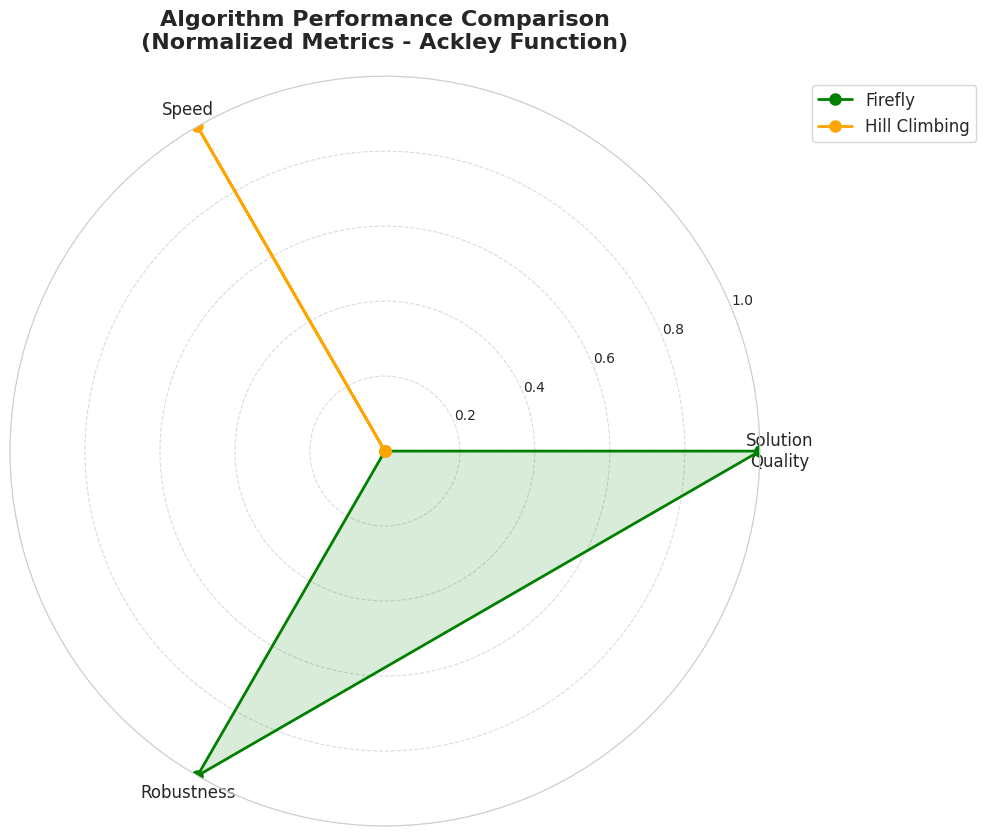

In [15]:
# Radar chart for overall comparison
def normalize_metric(values, higher_is_better=True):
    min_val, max_val = values.min(), values.max()
    if max_val == min_val:
        return np.ones_like(values)
    normalized = (values - min_val) / (max_val - min_val)
    return normalized if higher_is_better else 1 - normalized


radar_data = (
    all_results.groupby("Algorithm")
    .agg(
        {
            "Best Value": "mean",
            "Mean Time (s)": "mean",
            "Std Value": "mean",
        }
    )
    .reset_index()
)

# Normalize (higher is better after normalization)
radar_data["Quality_norm"] = normalize_metric(
    radar_data["Best Value"].values, False
)  # Lower is better
radar_data["Speed_norm"] = normalize_metric(
    radar_data["Mean Time (s)"].values, False
)  # Lower is better
radar_data["Robustness_norm"] = normalize_metric(
    radar_data["Std Value"].values, False
)  # Lower std is better

# Create radar chart
categories = ["Solution\nQuality", "Speed", "Robustness"]
N = len(categories)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="polar"))

colors = ["green", "orange"]
for idx, row in radar_data.iterrows():
    values = [
        row["Quality_norm"],
        row["Speed_norm"],
        row["Robustness_norm"],
    ]
    values += values[:1]

    ax.plot(
        angles,
        values,
        "o-",
        linewidth=2,
        label=row["Algorithm"],
        color=colors[idx],
        markersize=8,
    )
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], size=10)
ax.grid(True, linestyle="--", alpha=0.7)
ax.set_title(
    "Algorithm Performance Comparison\n(Normalized Metrics - Ackley Function)",
    size=16,
    fontweight="bold",
    pad=20,
)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.0), fontsize=12)

plt.tight_layout()
plt.show()

## 8. Conclusions

### Kết luận từ việc so sánh trên Ackley Function:

#### 1. **Convergence Speed (Tốc độ hội tụ)**
- **Hill Climbing**: Converge nhanh trong vài bước đầu nhưng dễ bị stuck ở local minima
- **Firefly**: Converge chậm hơn nhưng có khả năng escape local minima và tìm global optimum tốt hơn

#### 2. **Computational Complexity (Độ phức tạp)**
- **Hill Climbing**: Rất nhanh, ít evaluations (O(n) neighbors per iteration), phù hợp khi cần tốc độ
- **Firefly**: Nhiều evaluations hơn (O(n²) distance calculations), nhưng explore search space toàn diện hơn

#### 3. **Robustness (Tính bền vững)**
- **Hill Climbing**: Variance rất cao, phụ thuộc nhiều vào initial solution, dễ bị trap ở local minima
- **Firefly**: Consistent hơn nhờ population-based approach, ít phụ thuộc vào starting point

#### 4. **Scalability (Khả năng mở rộng)**
- **Hill Climbing**: Struggle với high dimensions do search space lớn và nhiều local minima
- **Firefly**: Scale tốt hơn với high dimensions nhờ swarm intelligence và global search capability

### Khuyến nghị:
- **Sử dụng Hill Climbing**: Khi cần tốc độ, search space đơn giản, ít local minima, hoặc làm local refinement
- **Sử dụng Firefly**: Khi bài toán có nhiều local minima, cần global optimum, high-dimensional problems
- **Trade-off**: Hill Climbing = speed + simplicity, Firefly = quality + robustness

### Key Insight:
Ackley function có rất nhiều local minima, điều này làm Hill Climbing (traditional search) gặp khó khăn. Firefly (swarm intelligence) vượt trội hơn rõ rệt nhờ khả năng exploration và communication giữa các agents.